# Function for closing the mesh (Necessary for calculating the volume

In [11]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
from ddgclib._particle_liquid_bridge_20240303 import *

In [12]:
# open boundary file

def open_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)


In [13]:
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

    #boundary_top.append(vat)
    #print(f'vat = {vat}')
    #HC.V.remove(vat)
    #boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom, vat, vab

# Functions for the contact-angle calculation

In [14]:
def b_disc_angle(v, r, bV, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)

    vij = []
    for vn in v.nn:
        if vn in bV:
            continue
        else:
            vij.append(vn)

    if 0:
        for vn in v.nn:
            if vn in bV:
                vij.append(vn)


    E_ij = vij[0].x_a - v.x_a
    E_ik = vij[1].x_a - v.x_a
    E_ij_ik = np.cross(E_ij, E_ik)
    E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
    dir_vec = E_ij_ik / E_ij_ik_norm

    if np.dot(N_f0, dir_vec) < 0:
        dir_vec = - dir_vec

    #K_H_i = c_outd['K_H_i']
    HNdA_i = c_outd['HNdA_i']
    C_ij = c_outd['C_ij']
    #HN_i = np.sum(HNdA_i) / np.sum(C_ij)
    n_i = c_outd['n_i']
    HN_i = np.sum(np.dot(HNdA_i, n_i)) / np.sum(C_ij)
    K_H_i = (HN_i/ 2.0)**2


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
       # print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')
        print(f'phi_est = {phi_est * 180 / np.pi}')
        print(f'E_ij = {E_ij}')
        print(f'E_ik = {E_ik}')
        print(f'E_ij_ik = {E_ij_ik}')
        print(f'dir_vec = {dir_vec}')
        print(f'np.dot(E_ij_ik_norm, dir_vec) = {np.dot(E_ij_ik_norm, dir_vec)}')
        print(f'E_ij_ik_norm = {E_ij_ik_norm}')
        print(f'vij = {vij}')

    return phi_est, dir_vec, E_ij, E_ik, E_ij_ik# , de # (sum of edge lengths)

# Functions for Particle-Particle liquid bridge

In [15]:

def fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax, contact_angle = True, load_activated = False,itermax_load = 10, save_activated = False,volume_constraint = False, V_init = 1):
    '''
    length = length of the inital cone [m]
    tau = size of time step [-]
    d_l = diameter one the lower site of the initial cyliner [m]
    d_u = diameter one the upper site of the initial cyliner [m]
    refinement = number of refinement of the mesh [-]
    theta_c = value of the contact angle in radian [rad]
    gamma = surface_tension [N/m]
    breaking_condition = when this value is reached, the simulation is finished [m]
    itermax = another breaking condition depending on the iteration steps [-]
    contact_angle = is the contact angle actived
    load_activated = with this parameter you have the choice to load a complex instead of creating a new on.
        if load_activated = False: A new mesh will be generated
    itermax_load = number of iteration of the loading complex (necessary paramter for loading the complex function:
    save_activated = with this parameter you have the choice to save the final complex
        if save_activated=False: Nothing happens
        if save_activated=True: The complex will saved under a savename depending on the inital parameters
    '''
    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')

    r_l = d_l / 2
    r_u = d_u / 2

    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''
    if load_activated:
        load_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_load)+'.json'
        HC = Complex(3)
        HC.load_complex(load_filename)
    else:
        HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)


    # Define bottom boundary condition
    boundary_bottom = []
    N_f0_vectors_pairs = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)
    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

    # runvariable for the iteration tracking
    residual_iteration = 0

    #HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom)
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []
    contact_angle_list_bottom   = []
    contact_angle_list_top      = []

    '''
    ---------------------------------------------------------------------------------------------------------------------------
    From here, the optimization is started
    '''
    iters = 0
    while True:


        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')
            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")
            break
        '''
        Calculating the volume of the hole mesh in every volume
        '''

        if volume_constraint:
            V_current = 0
            number_v = 0
            HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom) # closing the boundary

            for v in HC.V:
                number_v += 1
                V_ijk = volume(v)
                V_current += np.sum(V_ijk)

            V_current = V_current/12

            dV = (V_init-V_current)/V_init
            volume_list.append(V_current)
            HC.V.remove(vat) # Open the boundary (Important, otherwise the angle-calculation will not work)
            HC.V.remove(vab) # Open the boundary (Important, otherwise the angle-calculation will not work)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}

        contact_angle_list_bottom_dummy = []
        contact_angle_list_top_dummy   = []
       # print(f'number of vertexes = {number_v}')
        cHC = copy.copy(HC)

        for v in cHC.V:
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])

            # Define bottom boundary condition
            if v in set(boundary_bottom):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_bottom, print_out=False)
                contact_angle_list_bottom_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)

                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) *gamma * dE
                        vnn_factor = F_b * dir_vec
                       # vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec

                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Define top boundary condition
            if v in set(boundary_top):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_top, print_out=False)
               # contact_angle_list_top_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)
                for vnn in v.nn:
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                        contact_angle_list_top_dummy.append(phi_est)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) * gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys() and contact_angle:
                db = v_boundary_interior[v.x]  # normalized(HNdA_i)[0]
              #  df = np.zeros_like(HNdA_i)
               # df[0] = 0
               # df[1] = 0
               # df[2] = 0
               # db[2] = 0
            else:
                pass

            # Step in time
            if iters < 75:
                db = np.zeros_like(HNdA_i)
            else:
                db = db


            db = np.dot(db, N_f0)*N_f0
           # db = np.dot(db, dir_vec)*dir_vec
           # df = np.dot(df, N_f0)*N_f0
           # df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
           # dV =
            #v_new = v.x_a - tau/2 * df  + tau/2 * db old

            if contact_angle: # condition if the contact angle is activated
                v_new = v.x_a - tau/2 * df  + tau/2 * db
            else:
                v_new = v.x_a - tau/2 * df

            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df+db))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        #contact_angle_list_bottom_dummy.append(phi_est) theta_p_approx * 180 / np.pi
        contact_angle_list_bottom.append(cal_average(contact_angle_list_bottom_dummy)* 180 / np.pi)
        contact_angle_list_top.append(cal_average(contact_angle_list_top_dummy)* 180 / np.pi)

        iters += 1
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break


    if save_activated:
        if load_activated:
            itermax_save = itermax + itermax_load
        else:
            itermax_save = itermax

        save_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_save)+'.json'
        save_complex(HC, save_filename)
        print(f'Complex is saved under the name: {save_filename}.')

    return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max)

   # return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max,contact_angle_list_top_dummy)





# Variation and execution of the particle-particle-liquid function

In [16]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
'''
d_l = 0.8e-3 # radian on the lower side of the cone
d_l = 1.6e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 0.36 * 3e-3
d_l = d_u
length = 0.7e-3 # length of the cone
length = 0.294 * 3e-3
'''



tau = 0.1    # Endtime for calculation
tau = 0.7    # Endtime for calculation
itermax = 2



itermax_load = 800 # number of iteration of the loaded complex

'''
from Liam 19939
'''
r_i = 1e-3 # Particle Radian
#r_i = 1.0
gamma = 72.28e-3
#gamma = 72.28

#gamma = 2.45e-3  # N/m, surface tension of di-n-butyl phthalate/liquid paraffin mixture
#r_i = 15e-3 # Particle Radian

angle = 10 # angle from the liquid bridge depending of the particle-radian
S = 0.1 # dimensionless seperation distance
S = 0.3 # dimensionless seperation distance

y_i = np.sin(angle * np.pi/180.0) * r_i # calculated radian of the liquid bridge
d_l = 2 * y_i
d_u = d_l
length = S * r_i


# TEST angle:
theta_p = 60 * np.pi/180.0  # Three phase contact angle

'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''
#length = 2
#d_l = 1
#d_u = d_l


breaking_condition = 1e-9

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)
#fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_p,tau, gamma, breaking_condition,itermax,contact_angle = False, save_activated=False, load_activated=False, itermax_load = itermax_load)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)

HC = dummy_parameter2[0]
iteration_list = dummy_parameter2[1]
df_list_min = dummy_parameter2[2]
df_list_max = dummy_parameter2[3]
volume_list = dummy_parameter2[4]
contact_angle_list_bottom = dummy_parameter2[5]
contact_angle_list_top = dummy_parameter2[6]
N_f0_vectors_pairs = dummy_parameter2[7]
dHNdA_list_min = dummy_parameter2[8]
#ccHCV = dummy_parameter2[9]
#dHNdA_list_max = dummy_parameter2[9]
#dHNdA_list_dummy = dummy_parameter2[10]
#contact_angle_list_top_dummy = dummy_parameter2[11]


plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

Simulation is started!
-------------------------------------
number of iteration =1
number of iteration =2
number of iteration =3
-------------------------------------
Too many iterations! Simulation is canceled!
Time elapsed for canceled Simulation: 0.59 s
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [

AttributeError: 'numpy.ndarray' object has no attribute 'x_a'

In [9]:
from ddgclib._plotting import *
plot_polyscope(HC)
#gamma

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [10]:
volume_list

[]

In [28]:
y_i

0.00017364817766693034

# Plotting of the results

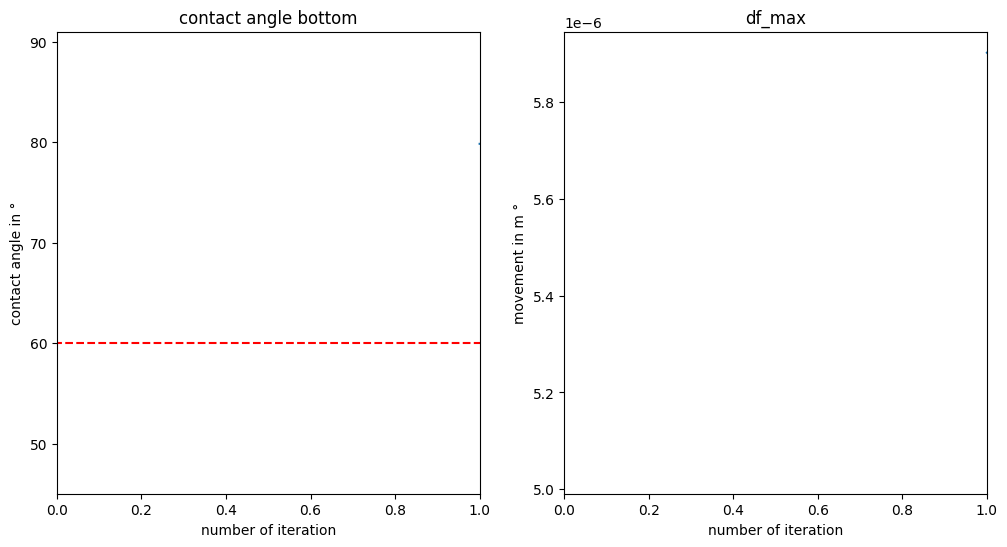

In [29]:
'''
Plot of the residual data
'''

#fig_name = "contact_angle_notactivated10_20240219.png"
fig_name = "contact_angle_activated57_20240219_2_4000iteration.png"
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, contact_angle_list_bottom)
ax[0].hlines(60,-10,2300, colors = 'red', linestyle = '--')

#ax[0].set_yscale('log')

#ax[1].plot(iteration_list, contact_angle_list_top)
ax[1].plot(iteration_list, df_list_max)
#ax[1].plot(iteration_list, dHNdA_list_min)

#hlines(y, xmin, xmax, colors=None, linestyles='solid'

ax[0].set_title('contact angle bottom')
ax[1].set_title('df_max')

ax[0].set_xlabel("number of iteration")
ax[0].set_ylabel("contact angle in °")

ax[1].set_xlabel("number of iteration")
ax[1].set_ylabel("movement in m °")

ax[0].set_ylim(45, 91)
ax[0].set_xlim(0, itermax)

#ax[1].set_ylim(0, 91)
ax[1].set_xlim(0, itermax)



fig.savefig(fig_name)

In [30]:
print(length)
print(d_u)

0.0003
0.0003472963553338607


In [31]:
a = np.array([-0.000122787809,-0.000122787809,9.9999e-5]) # erster Vektor am Rand
b = np.array([-0.000106318374, -0.000106318374, 8.74999969e-5]) # zweiter Vektor genau darunter
c = np.array([-5.35600375e-5, -0.000129305365, 9.37500008e-5]) # dritter Vektor rechts daneben
d = np.array([-0.0001299367, -5.38215463e-5, 9.37500008e-5]) # vierter Vektor links daneben
e = np.array([-3.18986532e-20, -0.000173648179,9.99999975e-5]) # theoretisch auf gleicher Höhe


def fun_dummy(x,y):
    result = np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y))
    angle_xxx = np.arccos(result)
    print(f'result = {result}')
    print(f'angle = {angle_xxx*180/np.pi}')

fun_dummy(a,e)

result = 0.7800492693971863
angle = 38.73491331714494


In [32]:
for i in range(len(contact_angle_list_top_dummy)):
    contact_angle_list_top_dummy[i]=contact_angle_list_top_dummy[i]/ 180 * np.pi

print(contact_angle_list_top_dummy)

NameError: name 'contact_angle_list_top_dummy' is not defined

In [ ]:
print(f'contact angle = {min(contact_angle_list_top)}')
print(f'volume = {volume_list[-1]*10e11}')
print(f'df_max = {df_list_max[-1]}')

In [ ]:
'''
Some not ready defined functions
'''
def b_force(v, theta_p, print_out=True):
    """
    The force on the three-phase contact angle
    Theta_i: Estimated sector angle of vertex i
    theta_p: Equilibrium three-phase contact angle
    """


    phi_est, l_a = b_disc_angle(v)
    # Compute boundary forces
    # N m-1
    gamma_bt = gamma * (np.cos(phi_est)
                        - np.cos(theta_p)) * np.array([0, 0, 1.0])

    if print_out:
        print(f'phi_est  = {phi_est * 180 / np.pi}')
        #print(f'dK[i] = {dK[i]}')
    return gamma_bt


def b_move_vertex(v, Theta_i, theta_p, print_out=True):
    """
    Move the boundary vertex
    """

    F_bt = gamma_bt * l_a  # N
    new_vx = v.x + 1e-1 * F_bt
    new_vx = tuple(new_vx)
    HC.V.move(v, new_vx)
    bV_new.add(HC.V[new_vx])

In [ ]:
'''
Plotting of the normvecs (dir_vecs)
'''

plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

# Using the Function